In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import itertools

import json
import os

import networkx as nx

import random

from joblib import Parallel, delayed

import logging

from sklearn.decomposition import PCA

In [27]:
from typing import List

In [35]:
import joblib

In [28]:
%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from Benchmarks.benchmark import generate_save_benchmark_dataset

from CustomAbstraction.CustomAbstractionHelper import StateModel, print_states, collect_state_field, getStateTransitionMatrix, calculate_state_transition

# from QuadraticConstraintModel import train_COF_on_leaves, get_h_from_COF

# from QuadraticConstraintModel import get_feature_bounds_from_COF, predict_from_COF, get_elevated_vertices

# from QuadraticConstraintModel import get_leaf_samples

from Optimizers.QuadraticConstraintModel import gurobi_minimax, cvxpy_minimax, train_States_on_leaves_parallel, predict_by_bounds, predict_with_tree
from Helping_Code.HelpingFunctions import normalized_root_mean_square_error

from SpaceEx.CustomAbstraction_to_SpaceEx import export_spaceex
from SpaceEx.RunSpaceexTest import run_spaceex


In [30]:
from Helping_Code.HelpingFunctions import get_leaf_samples
from Helping_Code.HelpingFunctions import load_dataset

In [31]:
from Helping_Code import CustomHyperrectangle
from Helping_Code.plot import CustomPlotClass

# customHyperrectangle = CustomHyperrectangle.CustomHyperrectangle()
customPlot = CustomPlotClass.CustomPlotClass()

# Helping code

In [32]:
def plotHyperrectanglesOfStateSpace(vertices_of_hyperrectangle, title="partitions of state space", savePath=None):
    num_of_vertices = vertices_of_hyperrectangle[0].shape[0]
    # print(f"number of vertices = {num_of_vertices}")
    if num_of_vertices == 4:
        customPlot.draw2DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            color='#8f9119',
            title=title,
            savePath=savePath
        )

    elif num_of_vertices == 8:
        # 3D Hyperrectangles
        customPlot.draw3DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            interactive=True,
            title=title,
            savePath=savePath
        )
    else:
        # Higher-dimensional hyperrectangles → reduce to 3D using PCA
        projected_vertices = []
        for verts in vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            projected_vertices.append(verts_reduced)

        customPlot.draw3DHyperrectanglesWithVertices(
            projected_vertices,
            interactive=True,
            title=title,
            savePath=savePath
        )


def plotElivatedHyperrectangles(vertices_of_hyperrectangle, elevated_vertices_of_hyperrectangle, title="Elevated Hyper Rectangles", savePath=None):
    num_of_vertices = vertices_of_hyperrectangle[0].shape[0]

    if num_of_vertices == 4:
        # 2D polytopes
        customPlot.drawDual2DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            elevated_vertices_of_hyperrectangle,
            color1='#8f9119',
            color2='#197b91',
            title=title,
            savePath=savePath
        )
    elif num_of_vertices == 8:
        # 3D polytopes
        customPlot.drawDual3DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            elevated_vertices_of_hyperrectangle,
            color1='#8f9119',
            color2='#197b91',
            title=title,
            savePath=savePath
        )
    else:
        # Higher-dimensional hyperrectangles → reduce to 3D using PCA
        projected_vertices = []
        for verts in vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            projected_vertices.append(verts_reduced)

        elevated_projected_vertices = []
        for verts in elevated_vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            elevated_projected_vertices.append(verts_reduced)

        
        # Fallback for other cases
        customPlot.drawDual2DHyperrectanglesWithVertices(
            projected_vertices,
            elevated_projected_vertices,
            title=title,
            savePath=savePath
        )



def plotDistanceBetweenTwoHyperrectangles(elevated_vertices, vertices_of_hyperrectangle, savePath="", title="Hyperrectangle Minimum Distance"):
    
    # Get closest points and distance
    X_opt, Xp_opt, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(
        elevated_vertices, vertices_of_hyperrectangle
    )
    
    # Determine dimension
    dim = elevated_vertices.shape[1]
    
    if dim == 2:
        # 2D plotting
        plt.figure()
        
        def plot_2d_hyperrectangle(vertices, color='cyan', alpha=0.3):
            from scipy.spatial import ConvexHull
            hull = ConvexHull(vertices)
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color=color, alpha=alpha)
            plt.plot(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'k-', linewidth=1)
        
        # Plot rectangles
        plot_2d_hyperrectangle(elevated_vertices, color='cyan', alpha=0.3)
        plot_2d_hyperrectangle(vertices_of_hyperrectangle, color='orange', alpha=0.3)
        
        # Plot closest points
        plt.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated rectangle')
        plt.scatter(*Xp_opt, color='red', s=50, label='Closest point on rectangle')
        
        # Draw line connecting closest points
        plt.plot([X_opt[0], Xp_opt[0]], [X_opt[1], Xp_opt[1]], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.legend()
        plt.axis('equal')
        plt.savefig(savePath)
        plt.show()
        
    else:
        # 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        def plot_3d_hyperrectangle(ax, verts, color='cyan', alpha=0.3):
            faces = np.array([[0, 1, 3, 2], [0, 1, 5, 4], [0, 2, 6, 4],
                              [1, 3, 7, 5], [2, 3, 7, 6], [4, 5, 7, 6]])
            poly3d = [[verts[idx] for idx in face] for face in faces]
            ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=alpha))
        
        # Plot hyperrectangles
        plot_3d_hyperrectangle(ax, elevated_vertices, color='cyan', alpha=0.3)
        plot_3d_hyperrectangle(ax, vertices_of_hyperrectangle, color='orange', alpha=0.3)
        
        # Plot closest points
        ax.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated hyperrectangle')
        ax.scatter(*Xp_opt, color='red', s=50, label='Closest point on hyperrectangle')
        
        # Draw line connecting closest points
        line_pts = np.vstack([X_opt, Xp_opt])
        ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
        
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(title)
        ax.legend()
        plt.savefig(savePath)
        plt.show()
    


In [45]:
import matplotlib.pyplot as plt
import networkx as nx

# Define your states and transition_to
# Each state will have an index and a list of transitions (indices of next states)

def plot_state_automata(states, title, savePath = None):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes (states)
    for i, state in enumerate(states):
        G.add_node(i, label=state.state_identifier)
    
    # Add edges based on transitions
    for i, state in enumerate(states):
        for next_state_idx in state.transition_to:
            G.add_edge(i, next_state_idx, label=f'{states[i].state_identifier} -> {states[next_state_idx].state_identifier}')
    
    # Create a layout for the graph (positions of nodes)
    pos = nx.spring_layout(G, seed=42)  # This gives a good-looking layout
    
    # Draw the graph
    plt.figure(figsize=(8, 8))
    
    # Draw nodes (states)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)
    
    # Draw edges (transitions)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray')
    
    # Draw labels for nodes (state identifiers)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')
    
    # Draw edge labels (transition labels)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    
    # Title and display the plot
    plt.title("Automaton State Transition Graph", fontsize=18)
    plt.axis('off')  # Hide axes for better aesthetics
    if savePath:
        plt.savefig(savePath, dpi=300)
    plt.show()


In [48]:
name_of_systems = [ "jet", "exp", "steam","nl1", "nl2"] # "navigation_old", "lin", "vdp", "sine2d", "tank"
list_of_n_samples = [ 100000, 30000, 60000, 100000, 1000000] # 500000, 

In [51]:
initials = { "jet" : 'x0>= 0.45 & x0 <= 0.5 & x1 >= -0.6 & x1 <= -0.55 & u0==0 & u1==0 & t==0 ',
             "exp" : 'x0>=0.45 & x0<=0.5 & x1>=0.86 & x1 <= 0.91 & u0==0 & u1==0 & t==0 ',
             "steam": 'x0>=0.7 & x0<=0.75 & x1>=-0.05 & x1<=0.05 & x2>=0.7 & x2<=0.75 & u0==0 & u1==0 & t==0',
             "nl1": 'x0>= 0 & x0 <= 0.05 & x1 >= 0 & x1 <= 0.1 & u0==0 & u1==0 & t==0',
             "nl2": 'x0<=0.025 & x0>=-0.025 & x1>=-0.9 & x1 <= -0.85 & u0==0 & u1==0 & t==0 ',
             # tank --> 'x0<=0.01 & x0 >= 0.0 & u0==0 & t==0 '
           }
initial_boxes = {
    "jet" :[(0.45, 0.5),    (-0.6,  -0.55)],        # 1: x0, x1
    "exp" : [(0.45, 0.5),    (0.86,   0.91)],        # 2: x0, x1
    "steam": [(0.7,  0.75),   (-0.05,  0.05), (0.7, 0.75)],  # 3: x0, x1, x2  <-- 3D
    "nl1": [(0.0,  0.05),   (0.0,    0.1)],         # 4: x0, x1
    "nl2": [(-0.025, 0.025),(-0.9,  -0.85)],        # 5: x0, x1
    # tank --->[(0.0,  0.01)],                  # 6: x0 only (no x1 given)
}
forbiddens = {
    "jet" : "x0 >= 0.3 & x0 <=0.35 & x1 >=0.5 & x1 <=0.6 ",
    "exp" : 'x0 >= 0.3 & x0 <=0.4 & x1 >=0.5 & x1 <=0.6',
    "steam": 'x0 >=0.5 & x0 <=0.6 & x1 >=-0.4 & x1 <=-0.3 & x2 >=0.7 & x2 <=0.8',
    "nl1": 'x0>=0.35 & x0 <=0.45 & x1>=0.1 & x1<=0.2',
    "nl2": 'x0 <=0.05 & x0 >= -0.05 & x1 >= -0.8 & x1 <=-0.7',
    # --> tank'x0 >= 2.0'
}

unsafe_boxes = {
    "jet" : [(0.3, 0.35),   (0.5, 0.6)],                 # 1: x0, x1
    "exp" : [(0.3, 0.4),    (0.5, 0.6)],                 # 2: x0, x1
    "steam": [(0.5, 0.6),    (-0.4, -0.3), (0.7, 0.8)],   # 3: x0, x1, x2 (3D)
    "nl1": [(0.35, 0.45),  (0.1, 0.2)],                 # 4: x0, x1
    "nl2": [(-0.05, 0.05), (-0.8, -0.7)],               # 5: x0, x1
    # --> tank[(2.0, None)],                                # 6: x0 lower-bounded only
}


Loaded dataset from Dataset/jet/jet_100000/data_jet_100000.csv
Name of the System =  jet
 Shape of X_Training = (90000, 2) 
 Shape of X_Testing = (10000, 2)
 Shape of Y_Training = (90000, 2) 
 Shape of Y_Testing = (10000, 2)
Number of the Leaves =  2
NRMSE [Tree Based] of Training =  0.11489049531792526
NRMSE [Tree Based] of Testing  =  0.1161478200482611
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.01325689942700301
NRMSE COF Based of Testing =  0.013407965227567131
Forbidden state values reached? Yes
Number of the Leaves =  4
NRMSE [Tree Based] of Training =  0.08521622343120006
NRMSE [Tree Based] of Testing  =  0.08653052536788805
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
NRMSE COF Based of Training =  0.0034992675294744694
NRMSE COF Based of Testing =  0.003535511540459924
Forbidden state values reached? Yes
Number of the Leaves =  6
NRMSE [Tree Based] of Training =  0.07147836745587668
NRMSE [Tree Based] of Testing  =  0.0728066263322456
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
NRMSE COF Based of Training =  0.0034979185051156607
NRMSE COF Based of Testing =  0.0035340736447715126


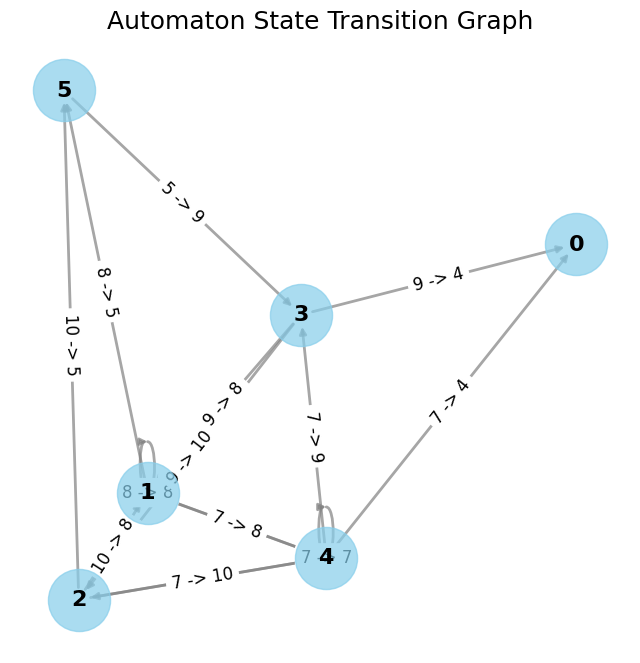

Generated and saved dataset to Dataset/exp/exp_100000/data_exp_100000.csv
Name of the System =  exp
 Shape of X_Training = (90000, 2) 
 Shape of X_Testing = (10000, 2)
 Shape of Y_Training = (90000, 2) 
 Shape of Y_Testing = (10000, 2)
Number of the Leaves =  2
NRMSE [Tree Based] of Training =  0.16211666052639945
NRMSE [Tree Based] of Testing  =  0.16171829032460772
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.15321883999035368
NRMSE COF Based of Testing =  0.1526964119306625
Forbidden state values reached? Yes
Number of the Leaves =  4
NRMSE [Tree Based] of Training =  0.11919423496427914
NRMSE [Tree Based] of Testing  =  0.11897399505436214
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
NRMSE COF Based of Training =  0.11303299202128111
NRMSE COF Based of Testing =  0.11180510351227861
Forbidden state values reached? Yes
Number of the Leaves =  6
NRMSE [Tree Based] of Training =  0.09970140238539142
NRMSE [Tree Based] of Testing  =  0.09913380593920872
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.06040229548658842
NRMSE COF Based of Testing =  0.059204666215747624
Forbidden state values reached? Yes
Number of the Leaves =  8
NRMSE [Tree Based] of Training =  0.08569065281615372
NRMSE [Tree Based] of Testing  =  0.08489728861034006
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.0603395711273107
NRMSE COF Based of Testing =  0.059143574742922915
Forbidden state values reached? Yes
Number of the Leaves =  10
NRMSE [Tree Based] of Training =  0.07982288040878194
NRMSE [Tree Based] of Testing  =  0.07882408783963808
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.06033936811111953
NRMSE COF Based of Testing =  0.059143388710988815
Forbidden state values reached? Yes
Number of the Leaves =  12
NRMSE [Tree Based] of Training =  0.07369698877819506
NRMSE [Tree Based] of Testing  =  0.07308219952707695
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.054144867139218594
NRMSE COF Based of Testing =  0.052899969441994314
Forbidden state values reached? Yes
Number of the Leaves =  14
NRMSE [Tree Based] of Training =  0.06738069341229364
NRMSE [Tree Based] of Testing  =  0.06641910064068338
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.04743109619125619
NRMSE COF Based of Testing =  0.046430486721246424
Forbidden state values reached? Yes
Number of the Leaves =  16
NRMSE [Tree Based] of Training =  0.06448899535372084
NRMSE [Tree Based] of Testing  =  0.06402708416762788
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for no

/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.04225895275662909
NRMSE COF Based of Testing =  0.0418737134991585
Forbidden state values reached? Yes
Number of the Leaves =  18
NRMSE [Tree Based] of Training =  0.061775065327894826
NRMSE [Tree Based] of Testing  =  0.06104921281414725
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non

/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.04187606978586657
NRMSE COF Based of Testing =  0.041492537064365315
Forbidden state values reached? Yes
Number of the Leaves =  20
NRMSE [Tree Based] of Training =  0.059038479462835906
NRMSE [Tree Based] of Testing  =  0.058222516103211906
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.041499807428533576
NRMSE COF Based of Testing =  0.04112501301452211
Forbidden state values reached? Yes
Number of the Leaves =  22
NRMSE [Tree Based] of Training =  0.056624539664618924
NRMSE [Tree Based] of Testing  =  0.05587900896012554
NRMSE COF Based of Training =  0.03955031050271226
NRMSE COF Based of Testing =  0.039010893889944484
Forbidden state values reached? Yes
Number of the Leaves =  24
NRMSE [Tree Based] of Training =  0.05412263434516817
NRMSE [Tree Based] of Testing  =  0.05356900085655171
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.03753404397155904
NRMSE COF Based of Testing =  0.03710947591344104
Forbidden state values reached? Yes
Number of the Leaves =  26
NRMSE [Tree Based] of Training =  0.0520228121366737
NRMSE [Tree Based] of Testing  =  0.05159373740380373
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.037527916961554955
NRMSE COF Based of Testing =  0.037104027012733125
Forbidden state values reached? Yes
Number of the Leaves =  28
NRMSE [Tree Based] of Training =  0.04998917060700851
NRMSE [Tree Based] of Testing  =  0.049636124155048235
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.034857139581446706
NRMSE COF Based of Testing =  0.03422508169241131
Forbidden state values reached? Yes
Number of the Leaves =  30
NRMSE [Tree Based] of Training =  0.047985555669523325
NRMSE [Tree Based] of Testing  =  0.047659518303788784
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
NRMSE COF Based of Training =  0.03186983177411625
NRMSE COF Based of Testing =  0.03172781566029041
Forbidden state values reached? Yes
Number of the Leaves =  32
NRMSE [Tree Based] of Training =  0.045968763573897585
NRMSE [Tree Based] of Testing  =  0.04573704933819728
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-pro

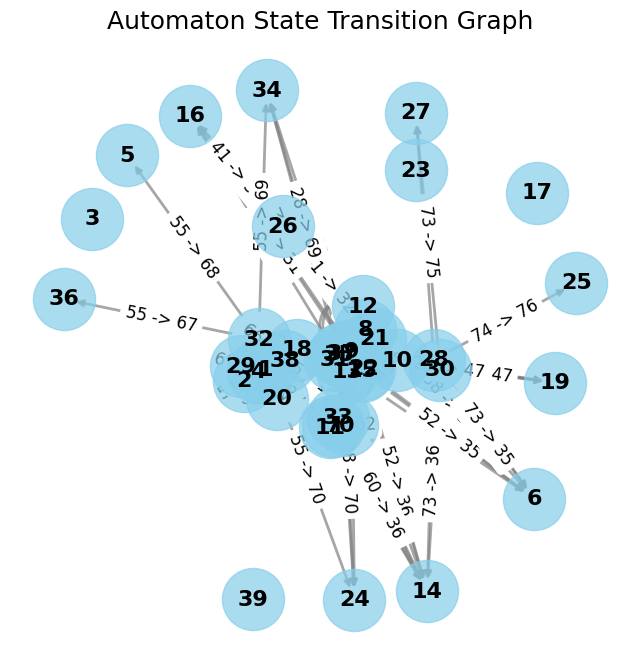

Loaded dataset from Dataset/steam/steam_100000/data_steam_100000.csv
Name of the System =  steam
 Shape of X_Training = (90000, 3) 
 Shape of X_Testing = (10000, 3)
 Shape of Y_Training = (90000, 3) 
 Shape of Y_Testing = (10000, 3)
Number of the Leaves =  2
NRMSE [Tree Based] of Training =  0.07647116573931194
NRMSE [Tree Based] of Testing  =  0.0775884282300919


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.017341685209639905
NRMSE COF Based of Testing =  0.017602009218602256
Forbidden state values reached? Yes
Number of the Leaves =  4
NRMSE [Tree Based] of Training =  0.04710551757099049
NRMSE [Tree Based] of Testing  =  0.047948416283488386
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-package

NRMSE COF Based of Training =  0.017357984479452658
NRMSE COF Based of Testing =  0.01761942964352701
Forbidden state values reached? Yes
Number of the Leaves =  6
NRMSE [Tree Based] of Training =  0.04187624529879102
NRMSE [Tree Based] of Testing  =  0.042543920847786125
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.01738402104035745
NRMSE COF Based of Testing =  0.01764776598581503
Forbidden state values reached? No


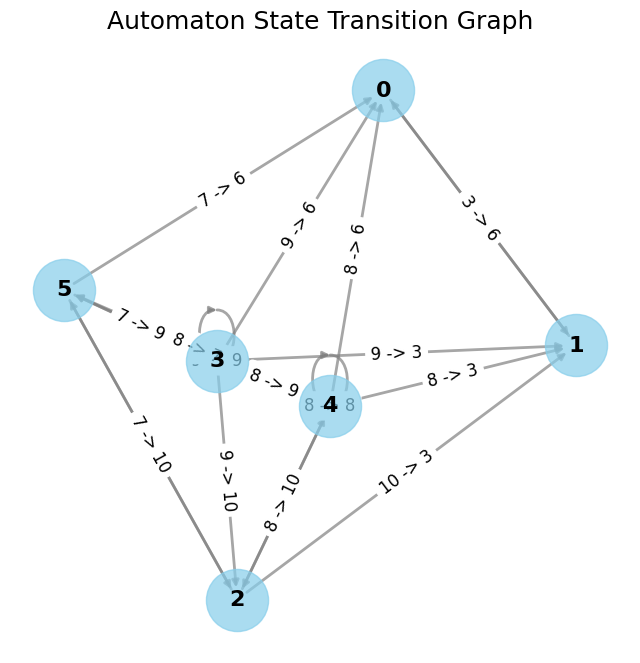

Loaded dataset from Dataset/nl1/nl1_100000/data_nl1_100000.csv
Name of the System =  nl1
 Shape of X_Training = (90000, 2) 
 Shape of X_Testing = (10000, 2)
 Shape of Y_Training = (90000, 2) 
 Shape of Y_Testing = (10000, 2)
Number of the Leaves =  2
NRMSE [Tree Based] of Training =  0.16167297259743366
NRMSE [Tree Based] of Testing  =  0.16234276515913423
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.0575648665351149
NRMSE COF Based of Testing =  0.05800227592340161
Forbidden state values reached? Yes
Number of the Leaves =  4
NRMSE [Tree Based] of Training =  0.11125552979574424
NRMSE [Tree Based] of Testing  =  0.11159966603360172
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
NRMSE COF Based of Training =  0.025345180290254312
NRMSE COF Based of Testing =  0.025380768657088645
Forbidden state values reached? No


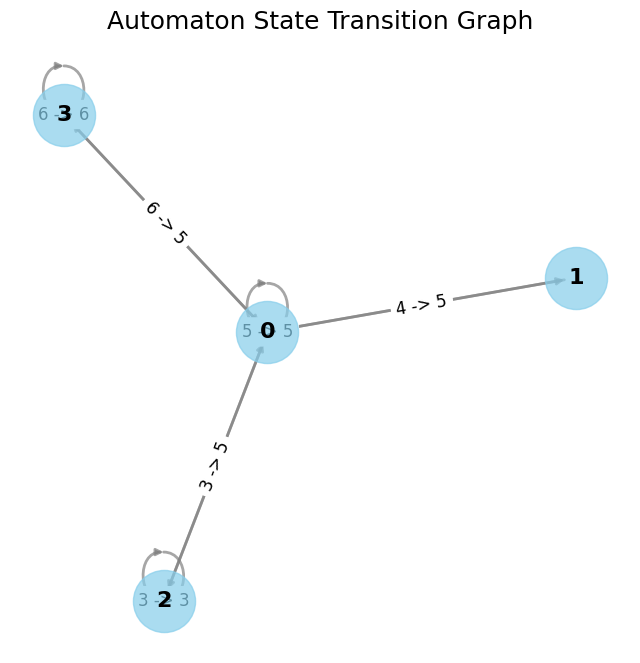

Generated and saved dataset to Dataset/nl2/nl2_100000/data_nl2_100000.csv
Name of the System =  nl2
 Shape of X_Training = (90000, 2) 
 Shape of X_Testing = (10000, 2)
 Shape of Y_Training = (90000, 2) 
 Shape of Y_Testing = (10000, 2)
Number of the Leaves =  2
NRMSE [Tree Based] of Training =  0.16035571037093402
NRMSE [Tree Based] of Testing  =  0.16130869598970965
NRMSE COF Based of Training =  0.052801675402872415
NRMSE COF Based of Testing =  0.05316399219477516
Forbidden state values reached? Yes
Number of the Leaves =  4
NRMSE [Tree Based] of Training =  0.1123051563730349
NRMSE [Tree Based] of Testing  =  0.1129317947851903
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.052752553637663964
NRMSE COF Based of Testing =  0.05311468174652148
Forbidden state values reached? Yes
Number of the Leaves =  6
NRMSE [Tree Based] of Training =  0.09686835717681624
NRMSE [Tree Based] of Testing  =  0.09707376537797142
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.029511847827868455
NRMSE COF Based of Testing =  0.029778385377694425
Forbidden state values reached? Yes
Number of the Leaves =  8
NRMSE [Tree Based] of Training =  0.08518523559382717
NRMSE [Tree Based] of Testing  =  0.08546070065365012
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.029146191855107046
NRMSE COF Based of Testing =  0.029411458411172417
Forbidden state values reached? Yes
Number of the Leaves =  10
NRMSE [Tree Based] of Training =  0.07527673271753375
NRMSE [Tree Based] of Testing  =  0.07578562836683143
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-package

NRMSE COF Based of Training =  0.029144772410296105
NRMSE COF Based of Testing =  0.02941033529568169
Forbidden state values reached? Yes
Number of the Leaves =  12
NRMSE [Tree Based] of Training =  0.07053534074778482
NRMSE [Tree Based] of Testing  =  0.0714437531588864
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non

/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-package

NRMSE COF Based of Training =  0.029144675859804153
NRMSE COF Based of Testing =  0.029410247270372083
Forbidden state values reached? Yes
Number of the Leaves =  14
NRMSE [Tree Based] of Training =  0.06602204595652475
NRMSE [Tree Based] of Testing  =  0.06681970327497797
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.023364026936826744
NRMSE COF Based of Testing =  0.023526687997340107
Forbidden state values reached? Yes
Number of the Leaves =  16
NRMSE [Tree Based] of Training =  0.061446659914831975
NRMSE [Tree Based] of Testing  =  0.0624187821659324
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for n

/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-package

NRMSE COF Based of Training =  0.016706480442586644
NRMSE COF Based of Testing =  0.016846660601900456
Forbidden state values reached? Yes
Number of the Leaves =  18
NRMSE [Tree Based] of Training =  0.05689578884421526
NRMSE [Tree Based] of Testing  =  0.05772604192157315
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-package

NRMSE COF Based of Training =  0.016705986257907757
NRMSE COF Based of Testing =  0.016846213314505774
Forbidden state values reached? Yes
Number of the Leaves =  20
NRMSE [Tree Based] of Training =  0.05246102768016346
NRMSE [Tree Based] of Testing  =  0.05304175928882046
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.01670519040799314
NRMSE COF Based of Testing =  0.016845402438565638
Forbidden state values reached? Yes
Number of the Leaves =  22
NRMSE [Tree Based] of Training =  0.05050242512225455
NRMSE [Tree Based] of Testing  =  0.050850379618558504
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.01665488412907512
NRMSE COF Based of Testing =  0.016794328922976755
Forbidden state values reached? Yes
Number of the Leaves =  24
NRMSE [Tree Based] of Training =  0.04875649812287698
NRMSE [Tree Based] of Testing  =  0.04921730101721858
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.016621782132321426
NRMSE COF Based of Testing =  0.016762944587530495
Forbidden state values reached? Yes
Number of the Leaves =  26
NRMSE [Tree Based] of Training =  0.047056148768266914
NRMSE [Tree Based] of Testing  =  0.047416353786254244
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/devunivaq/ResearchTasks/Extracting_BSR_Benchmark_Neural_Abstraction/venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


NRMSE COF Based of Training =  0.01661223531616606
NRMSE COF Based of Testing =  0.016753754707437344
Forbidden state values reached? No


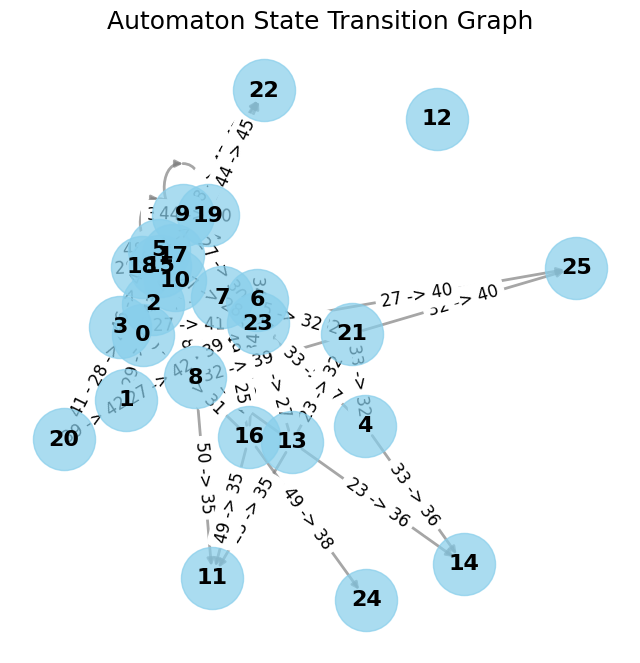

In [52]:
for sys_name in name_of_systems:
    for n_samples in list_of_n_samples[:1]:
        if sys_name == "navigation_old":
            X, y = load_dataset(f"Dataset/{sys_name}/{sys_name}_{n_samples}/data_{sys_name}_{n_samples}.csv",num_attributes=4, num_classes=4)
        else:
            X, y = generate_save_benchmark_dataset(benchmark_name = sys_name, n_samples=n_samples)
        # X, y = generate_save_benchmark_dataset(benchmark_name = sys_name, n_samples=n_samples)
        print("Name of the System = ", sys_name)
        X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1)
        print(f" Shape of X_Training = {X_train.shape} \n Shape of X_Testing = {X_test.shape}")
        print(f" Shape of Y_Training = {y_train.shape} \n Shape of Y_Testing = {y_test.shape}")
        current_max_leaf_nodes = 2
        loop_flag = True
        while(loop_flag):
            print("Number of the Leaves = ", current_max_leaf_nodes)
            tree = DecisionTreeRegressor(max_leaf_nodes=current_max_leaf_nodes)
            tree.fit(X_train, y_train)
            nrmse_tree_training = normalized_root_mean_square_error(y_train, tree.predict(X_train))
            print("NRMSE [Tree Based] of Training = ", nrmse_tree_training)
            nrmse_tree_testing = normalized_root_mean_square_error(y_test, tree.predict(X_test))
            print("NRMSE [Tree Based] of Testing  = ", nrmse_tree_testing)
            states = train_States_on_leaves_parallel(X_train, y_train, tree, optimizer="gurobi", n_jobs=-1)
            nrmse_COF_model_training = normalized_root_mean_square_error(y_train, predict_with_tree(X_train, tree, states))
            print("NRMSE COF Based of Training = ", nrmse_COF_model_training)
            nrmse_COF_model_testing = normalized_root_mean_square_error(y_test, predict_with_tree(X_test, tree, states))
            print("NRMSE COF Based of Testing = ", nrmse_COF_model_testing)
            state_transition_matrix = calculate_state_transition(states)
            initially = initials[sys_name]
            forbidden = forbiddens[sys_name]
            model_folder_path = f"/home/devunivaq/ResearchTasks/Neural-Abstractions-V2/SpaceEx/experiments/{sys_name}_{n_samples}/"
            os.makedirs(model_folder_path, exist_ok=True)
            export_spaceex(
                states= states,
                out_xml_path= f"{model_folder_path}/{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.xml",
                system_name=  f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_State_CustomAbstraction",
                T = 1.5,
                initial_box = initial_boxes[sys_name],
                unsafe_box = unsafe_boxes[sys_name],
                init_mode = "init_location"  # "init_location" (NA-like) or "global_initially"
            )
            forbidden_reached, output_text, error_text, polygons = run_spaceex(
                folder_model_xml_path = model_folder_path,
                sapceex_path="",
                model_file= f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_CA_spaceex.xml",
                system=f"{sys_name}_{n_samples}_{current_max_leaf_nodes}_State_CustomAbstraction",
                output_vars= ",".join(f"x{i}" for i in range(X_train.shape[1])),
                initially=initially,
                forbidden=forbidden,
                scenario="phaver",
            )
            print("Forbidden state values reached?", "Yes" if forbidden_reached else "No")
            loop_flag = forbidden_reached
            current_max_leaf_nodes = current_max_leaf_nodes + 2
            if not loop_flag:
                # Save
                joblib.dump(states, f"Dataset/{sys_name}/{sys_name}_{n_samples}/{sys_name}_{n_samples}_states.pkl")  # states: List[StateModel]
                
                # Load
                #states_reloaded: List[StateModel] = joblib.load("states.pkl")

                plot_state_automata(states, title=f"{sys_name} - {n_samples} - Leaves={current_max_leaf_nodes - 2}", savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/{sys_name}_{n_samples}_{current_max_leaf_nodes - 2}.png")
                
               

In [ ]:
states = train_States_on_leaves_parallel(X_train, y_train, tree, optimizer="gurobi", n_jobs=-1)

In [43]:
print_states(states, fields_to_print=['h'])

State 13, h=0.12835831599507894
State 11, h=0.12908652149126598
State 14, h=0.1286273868622173
State 10, h=0.1286542532327064
State 12, h=0.1286235170523362
State 9, h=0.12906955566653963
State 7, h=0.12960639627959336
State 8, h=0.1297043694537877


In [14]:
h_values = collect_state_field(states, field_name='h')
h_values

[0.007933907413728635,
 8.333781836644201e-05,
 0.0028191632485650006,
 0.0028245432883162217,
 0.005197324233635727,
 0.007945335509859675]

In [15]:
vertices = collect_state_field(states, field_name='vertices')
elevated_vertices = collect_state_field(states, field_name='image_vertices')

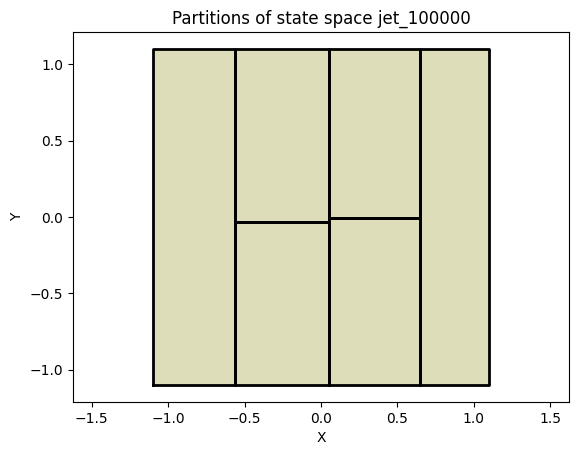

In [16]:

plotHyperrectanglesOfStateSpace(vertices, 
                                title=f"Partitions of state space {sys_name}_{n_samples}")



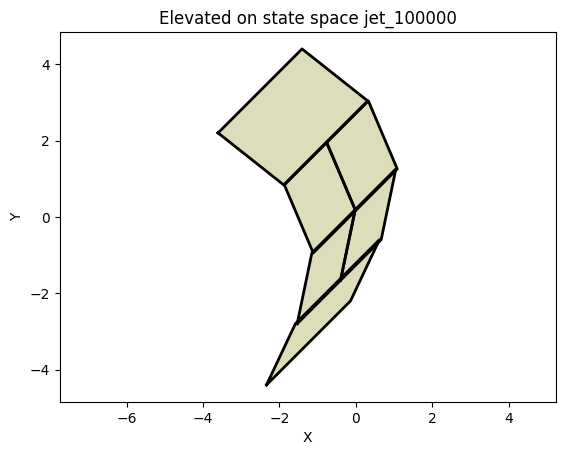

In [17]:

plotHyperrectanglesOfStateSpace(elevated_vertices, 
                                title=f"Elevated on state space {sys_name}_{n_samples}")



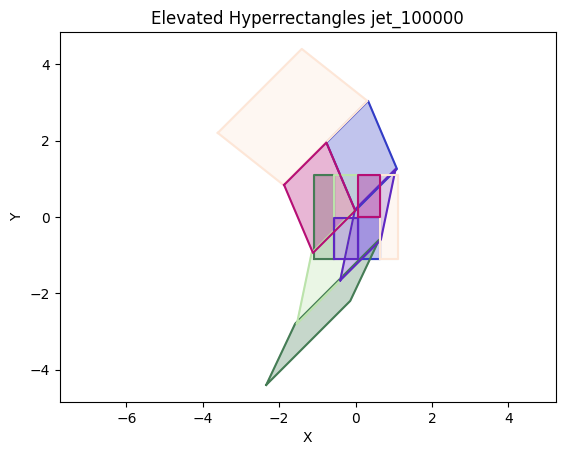

In [18]:

# Plot Dual Hyperrectangles
plotElivatedHyperrectangles(vertices, 
                            elevated_vertices,
                            savePath = None, title=f"Elevated Hyperrectangles {sys_name}_{n_samples}")



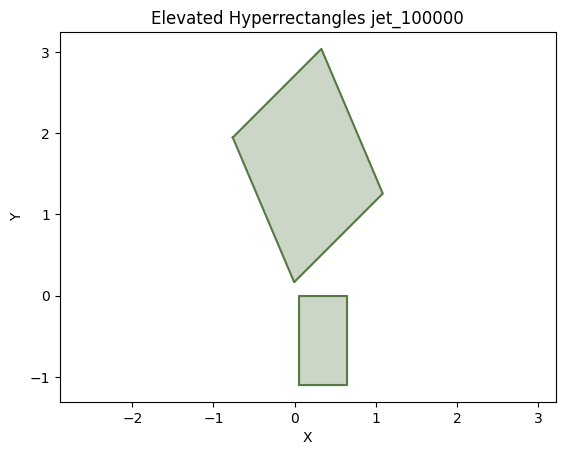

In [19]:

# Plot only one Dual Hyperrectangle
plotElivatedHyperrectangles(vertices[:1], 
                            elevated_vertices[:1],
                            savePath = None, title=f"Elevated Hyperrectangles {sys_name}_{n_samples}")



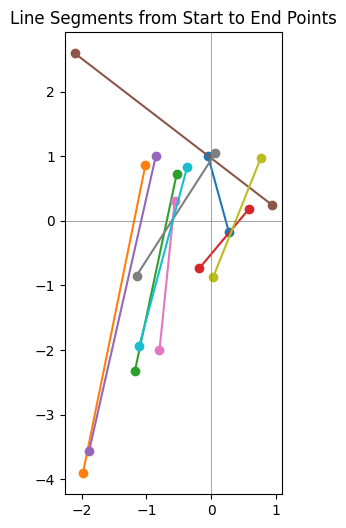

In [20]:
starts = X_train[:10]
ends = y_train[:10]
# Plot lines
plt.figure(figsize=(6,6))
for s, e in zip(starts, ends):
    plt.plot([s[0], e[0]], [s[1], e[1]], marker='o')

plt.axhline(0, color='gray', lw=0.5)  # optional axis lines
plt.axvline(0, color='gray', lw=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Line Segments from Start to End Points")
plt.show()

/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems With Non-Gaussian Noise via Formal Abstractions/Neural Abstractions/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


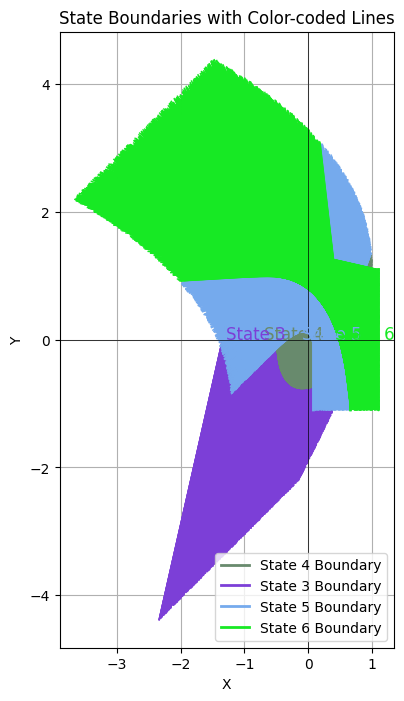

In [385]:
# Plotting the states and lines
plt.figure(figsize=(8, 8))

# Define a color map for the states
state_colors = {state.state_identifier: np.random.rand(3,) for state in states}

# Loop through states and plot their boundaries and lines
for state in states:
    color = state_colors[state.state_identifier]
    
    # Plot the boundary for each state using its vertices or bounds
    if state.vertices is not None:
        plt.plot(state.vertices[:, 0], state.vertices[:, 1], color=color, lw=2, label=f"State {state.state_identifier} Boundary")
    
    # Loop through X_train and y_train and plot lines for each state
    for idx, state_idx in enumerate(state.indices):  # Check if the point belongs to the state
        start_point = X_train[state_idx][:5]
        end_point = y_train[state_idx][:5]
        
        # Plot the line with the color associated with the state
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color=color, lw=1)

    # Add state identifier label near the boundary (centroid of the state)
    if state.vertices is not None:
        centroid = np.mean(state.vertices, axis=0)
        plt.text(centroid[0], centroid[1], f"State {state.state_identifier}", color=color, fontsize=12, ha='center')

# Customize plot appearance
plt.title("State Boundaries with Color-coded Lines")
plt.xlabel("X")
plt.ylabel("Y")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)

# Optionally, add a legend
plt.legend()

# Display plot
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [21]:
# state_transition_matrix = getStateTransitionMatrix(vertices_of_hyperrectangle=vertices, 
#                                                    elevated_vertices= elevated_vertices, h_values=h_values)
#state_transition_matrix = calculate_state_transition(states)
state_transition_matrix

array([[0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0.]])

In [22]:
state_transition_matrix.shape

(6, 6)

In [23]:
collect_state_field(states, field_name='transition_to')

[[2, 4, 5], [0], [1, 2, 3], [0, 2, 3, 4, 5], [], [1, 2, 3]]

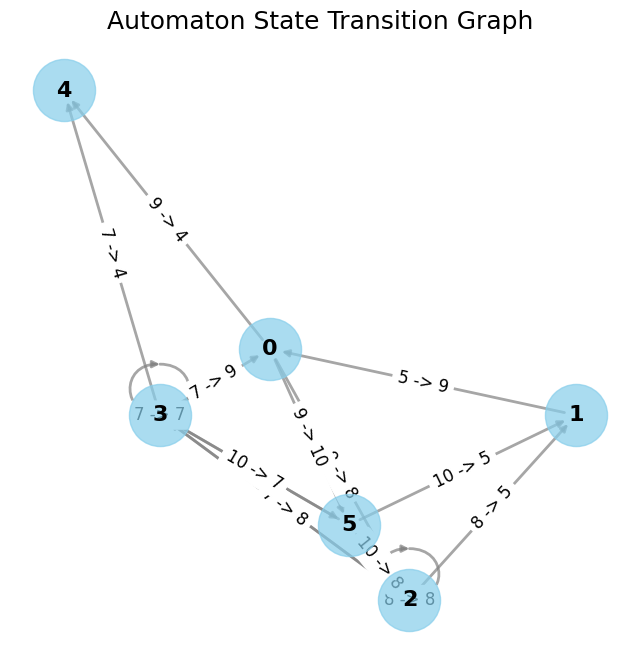

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

# Define your states and transition_to
# Each state will have an index and a list of transitions (indices of next states)


# Create a directed graph
G = nx.DiGraph()

# Add nodes (states)
for i, state in enumerate(states):
    G.add_node(i, label=state.state_identifier)

# Add edges based on transitions
for i, state in enumerate(states):
    for next_state_idx in state.transition_to:
        G.add_edge(i, next_state_idx, label=f'{states[i].state_identifier} -> {states[next_state_idx].state_identifier}')

# Create a layout for the graph (positions of nodes)
pos = nx.spring_layout(G, seed=42)  # This gives a good-looking layout

# Draw the graph
plt.figure(figsize=(8, 8))

# Draw nodes (states)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)

# Draw edges (transitions)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray')

# Draw labels for nodes (state identifiers)
nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

# Draw edge labels (transition labels)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Title and display the plot
plt.title("Automaton State Transition Graph", fontsize=18)
plt.axis('off')  # Hide axes for better aesthetics
plt.show()


In [ ]:
run_spaceex